### Importe de librerias

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras.utils.vis_utils import plot_model

np.random.seed(1)
tf.random.set_seed(1)

2022-12-05 13:33:54.614722: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Redes Neuronales

Datasets a utilizar

In [2]:
#datasets normales
ds_train = pd.read_csv('properati_argentina_train.csv')
ds_test = pd.read_csv('properati_argentina_test.csv')

### Ingenieria de caracteristicas para datasets compelto

In [3]:
ds_train.head()

,Unnamed: 0,id,latitud,longitud,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,precioxm2_relativo_q
0,0,CLj2GNCsBreAzTKFXCaLIQ==,-34.601807,-58.469965,Departamento,2.0,1.0,53.0,49.0,80000.0,bajo
1,1,TvqKIPzzT1urYfVhh8tC7w==,-34.580088,-58.424965,Departamento,2.0,1.0,35.0,35.0,79900.0,medio
2,2,QRs3RUjw1RS5/WRne8ApbA==,-34.551481,-58.452358,Departamento,1.0,1.0,25.0,20.0,69000.0,medio
3,3,ju90QBsV36i7DCOOWCJpaA==,-34.632290,-58.464844,Departamento,5.0,3.0,75.0,75.0,150000.0,medio
4,4,uxD4SK3jtGbmxfIlN03UMQ==,-34.549279,-58.463074,Departamento,2.0,1.0,46.0,34.0,85000.0,bajo


In [4]:
#dropeamos Unamed:0
ds_train.drop(columns=["Unnamed: 0"], inplace=True)
ds_test.drop(columns=["Unnamed: 0"], inplace=True)

#cambio nombre de columna precioxm2_relativo_q
ds_train.rename(columns={'precioxm2_relativo_q':'tipo_precio'}, inplace=True)
ds_test.rename(columns={'precioxm2_relativo_q':'tipo_precio'}, inplace=True)

Aplicamos dummies a la variable property_type

In [5]:
ds_train = pd.get_dummies(ds_train, columns=["property_type"], drop_first=True)

ds_test =  pd.get_dummies(ds_test, columns=["property_type"], drop_first=True)

In [6]:
ds_train['tipo_precio'].unique()

array(['bajo', 'medio', 'alto'], dtype=object)

Tengo que pasar estas clases a numeros para que funcionen con clasificacion. Hago un label encoder

In [7]:
tipo_precio_replace = {'bajo':0, 'medio':1, 'alto':2}

ds_train.loc[:, 'tipo_precio'].replace(tipo_precio_replace, inplace=True)
ds_test.loc[:, 'tipo_precio'].replace(tipo_precio_replace, inplace=True)

In [8]:
ds_train.head()

,id,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,tipo_precio,property_type_Departamento,property_type_PH
0,CLj2GNCsBreAzTKFXCaLIQ==,-34.601807,-58.469965,2.0,1.0,53.0,49.0,80000.0,0,1,0
1,TvqKIPzzT1urYfVhh8tC7w==,-34.580088,-58.424965,2.0,1.0,35.0,35.0,79900.0,1,1,0
2,QRs3RUjw1RS5/WRne8ApbA==,-34.551481,-58.452358,1.0,1.0,25.0,20.0,69000.0,1,1,0
3,ju90QBsV36i7DCOOWCJpaA==,-34.632290,-58.464844,5.0,3.0,75.0,75.0,150000.0,1,1,0
4,uxD4SK3jtGbmxfIlN03UMQ==,-34.549279,-58.463074,2.0,1.0,46.0,34.0,85000.0,0,1,0


In [9]:
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68012 entries, 0 to 68011
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          68012 non-null  object 
 1   latitud                     68012 non-null  float64
 2   longitud                    68012 non-null  float64
 3   property_rooms              68012 non-null  float64
 4   property_bedrooms           68012 non-null  float64
 5   property_surface_total      68012 non-null  float64
 6   property_surface_covered    68012 non-null  float64
 7   property_price              68012 non-null  float64
 8   tipo_precio                 68012 non-null  int64  
 9   property_type_Departamento  68012 non-null  uint8  
 10  property_type_PH            68012 non-null  uint8  
dtypes: float64(7), int64(1), object(1), uint8(2)
memory usage: 4.8+ MB


## Regresion

Funcion para graficar

In [10]:
features_regression = ['longitud', 'latitud', 'property_surface_total']
target_regression = ['property_price']

x_train_regress = ds_train.loc[:, features_regression]
x_test_regress = ds_test.loc[:, features_regression]
y_train_regress = ds_train.loc[:, target_regression]
y_test_regress = ds_test.loc[:, target_regression]

In [12]:
sscaler = StandardScaler()
sscaler.fit(x_train_regress)

StandardScaler()

In [13]:
x_train_regress = sscaler.transform(x_train_regress)
x_test_regress = sscaler.transform(x_test_regress)

#### Modelo de regresion

In [14]:
in_regress = len(features_regression)
out_regress = len(target_regression)

In [26]:
def regression_model_builder(hp):
    max_neurons = 50
    model = keras.Sequential()
    model.add(keras.Input(shape=(in_regress,)))
    
    hp_units_1 = hp.Int('units_1', min_value=1, max_value=max_neurons, step=1)
    hp_activation_1 = hp.Choice('activation_1', values=['tanh', 'sigmoid'])
    model.add(keras.layers.Dense(units=hp_units_1, activation=hp_activation_1, name="layer1"))
    
    hp_units_2 = hp.Int('units_2', min_value=1, max_value=max_neurons, step=1)
    hp_activation_2 = hp.Choice('activation_2', values=['relu', 'tanh', 'sigmoid'])
    model.add(keras.layers.Dense(units=hp_units_2, activation=hp_activation_2, name="layer2"))
    
    model.add(keras.layers.Dense(units=out_regress, name="output"))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.RootMeanSquaredError()]
    )
    
    return model

In [27]:
regress_tuner = kt.RandomSearch(
    regression_model_builder,
    objective='val_loss',
    max_trials=20
)

In [28]:
regress_history = regress_tuner.search(x_train_regress, y_train_regress.to_numpy(), epochs=100, batch_size=700, validation_split=0.2)

Trial 20 Complete [00h 00m 14s]
val_loss: 7561308672.0

Best val_loss So Far: 7561308672.0
Total elapsed time: 00h 05m 06s
INFO:tensorflow:Oracle triggered exit


In [31]:
best_regress_hps = regress_tuner.get_best_hyperparameters()[0]
print("Hiperparametros Optimos Encontrados")
print("  · Neuronas primera capa: ", best_regress_hps.get('units_1'))
print("  · Activavion primera capa: ", best_regress_hps.get('activation_1'))
print("  · Neuronas segunda capa: ", best_regress_hps.get('units_2'))
print("  · Activavion segunda capa: ", best_regress_hps.get('activation_2'))
print("  · Learning rate: ", best_regress_hps.get('learning_rate'))

Hiperparametros Optimos Encontrados
  · Neuronas primera capa:  15
  · Activavion primera capa:  tanh
  · Neuronas segunda capa:  8
  · Activavion segunda capa:  relu
  · Learning rate:  1e-06


In [33]:
regress_model = keras.Sequential(
    [
        keras.Input(shape=(in_regress,)),
        keras.layers.Dense(units=15, activation='tanh', name="layer1"),
        keras.layers.Dense(units=8, activation='relu', name="layer2"),
        keras.layers.Dense(units=out_regress, name="output")
    ]
)

In [34]:
regress_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 15)                60        
                                                                 
 layer2 (Dense)              (None, 8)                 128       
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 197
Trainable params: 197
Non-trainable params: 0
_________________________________________________________________


In [35]:
regress_model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=1e-6),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

In [36]:
regress_model.fit(x_train_regress, y_train_regress.to_numpy(), epochs=100, batch_size=700, validation_split=0.2)

Epoch 1/100
78/78 [==============================] - 1s 3ms/step - loss: 24982226944.0000 - root_mean_squared_error: 158057.6719 - val_loss: 14978891776.0000 - val_root_mean_squared_error: 122388.2812
Epoch 2/100
78/78 [==============================] - 0s 2ms/step - loss: 12666977280.0000 - root_mean_squared_error: 112547.6641 - val_loss: 10306050048.0000 - val_root_mean_squared_error: 101518.7188
Epoch 3/100
78/78 [==============================] - 0s 2ms/step - loss: 10245641216.0000 - root_mean_squared_error: 101220.7578 - val_loss: 11015341056.0000 - val_root_mean_squared_error: 104953.9922
Epoch 4/100
78/78 [==============================] - 0s 2ms/step - loss: 8606545920.0000 - root_mean_squared_error: 92771.4688 - val_loss: 8850996224.0000 - val_root_mean_squared_error: 94079.7344
Epoch 5/100
78/78 [==============================] - 0s 2ms/step - loss: 8431304704.0000 - root_mean_squared_error: 91822.1328 - val_loss: 8115366400.0000 - val_root_mean_squared_error: 90085.3203
Epo

78/78 [==============================] - 0s 2ms/step - loss: 7205652480.0000 - root_mean_squared_error: 84886.1172 - val_loss: 7624559104.0000 - val_root_mean_squared_error: 87318.7188
Epoch 43/100
78/78 [==============================] - 0s 2ms/step - loss: 7395918848.0000 - root_mean_squared_error: 85999.5312 - val_loss: 7220108800.0000 - val_root_mean_squared_error: 84971.2266
Epoch 44/100
78/78 [==============================] - 0s 2ms/step - loss: 7301633024.0000 - root_mean_squared_error: 85449.5938 - val_loss: 7847989760.0000 - val_root_mean_squared_error: 88588.8828
Epoch 45/100
78/78 [==============================] - 0s 2ms/step - loss: 7137904640.0000 - root_mean_squared_error: 84486.1172 - val_loss: 7217951744.0000 - val_root_mean_squared_error: 84958.5312
Epoch 46/100
78/78 [==============================] - 0s 2ms/step - loss: 7404760064.0000 - root_mean_squared_error: 86050.9141 - val_loss: 7986834432.0000 - val_root_mean_squared_error: 89369.0938
Epoch 47/100
78/78 [===

78/78 [==============================] - 0s 2ms/step - loss: 8093328896.0000 - root_mean_squared_error: 89962.9297 - val_loss: 7829528064.0000 - val_root_mean_squared_error: 88484.6172
Epoch 84/100
78/78 [==============================] - 0s 2ms/step - loss: 7625553408.0000 - root_mean_squared_error: 87324.4141 - val_loss: 7659168256.0000 - val_root_mean_squared_error: 87516.6719
Epoch 85/100
78/78 [==============================] - 0s 1ms/step - loss: 7725963264.0000 - root_mean_squared_error: 87897.4609 - val_loss: 8998870016.0000 - val_root_mean_squared_error: 94862.3750
Epoch 86/100
78/78 [==============================] - 0s 2ms/step - loss: 7924033536.0000 - root_mean_squared_error: 89017.0391 - val_loss: 7566609920.0000 - val_root_mean_squared_error: 86986.2656
Epoch 87/100
78/78 [==============================] - 0s 2ms/step - loss: 7385850880.0000 - root_mean_squared_error: 85940.9766 - val_loss: 7798422016.0000 - val_root_mean_squared_error: 88308.6719
Epoch 88/100
78/78 [===

In [37]:
y_pred_regress = regress_model.predict(x_test_regress)

532/532 [==============================] - 0s 723us/step


In [38]:
regress_rmse = mean_squared_error(
        y_true  = y_test_regress,
        y_pred  = y_pred_regress,
        squared = False
       )

print(f"La raiz del error cuadratico medio del test es: {regress_rmse:,.2f}")

La raiz del error cuadratico medio del test es: 81,477.49


Pareciera que la red se aprendio el promedio y siempre predice eso.

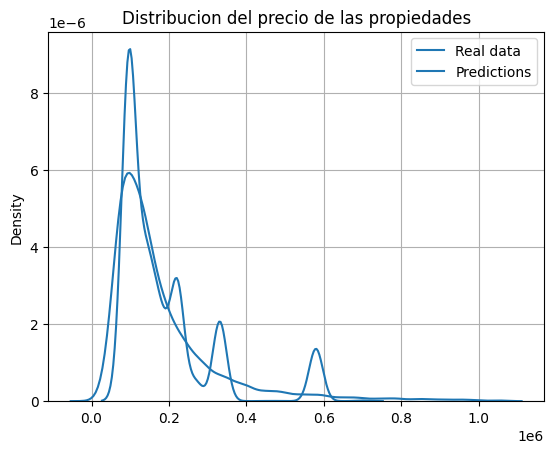

In [42]:
plt.grid(True)
sns.kdeplot(data=y_test_regress, label='Real data')
sns.kdeplot(data=y_pred_regress, label='Predictions')
plt.title("Distribucion del precio de las propiedades")
plt.legend()
plt.show()
# me salen los 2 graficos con el mismo color

Referencias:
- https://github.com/karndeepsingh/keras_tuner_implementation/blob/main/HYPER_OPTIMIZATION_OF_DEEP_LEARNING_MODELS_USING_KERAS_TUNER_.ipynb
- https://keras.io/keras_tuner/
- https://www.tensorflow.org/tutorials/keras/keras_tuner

## Clasificacion

In [9]:
ds_train.columns

Index(['id', 'latitud', 'longitud', 'property_rooms', 'property_bedrooms',
       'property_surface_total', 'property_surface_covered', 'property_price',
       'tipo_precio', 'property_type_Departamento', 'property_type_PH'],
      dtype='object')

In [36]:
features_classification = ['longitud', 'latitud', 'property_rooms', 'property_bedrooms',
                           'property_surface_total', 'property_surface_covered',
                           'property_type_Departamento', 'property_type_PH']
target_classification = 'tipo_precio'

x_train_class = ds_train.loc[:, features_classification]
x_test_class = ds_test.loc[:, features_classification]
y_train_class = ds_train.loc[:, target_classification]
y_test_class = ds_test.loc[:, target_classification]

In [37]:
numeric_features = ['longitud', 'latitud', 'property_rooms', 'property_bedrooms',
                    'property_surface_total', 'property_surface_covered']

sscaler = StandardScaler()
sscaler.fit(x_train_class.loc[:, numeric_features])

StandardScaler()

In [38]:
x_train_class.loc[:, numeric_features] = sscaler.transform(x_train_class.loc[:, numeric_features])
x_test_class.loc[:, numeric_features] = sscaler.transform(x_test_class.loc[:, numeric_features])

#### Modelo de clasificacion

In [39]:
d_in = len(features_classification)
d_out = len(y_train_class.unique())

In [46]:
def classification_model_builder(hp):
    max_neurons = 50
    model = keras.Sequential()
    model.add(keras.Input(shape=(d_in,)))
    
    hp_units_1 = hp.Int('units_1', min_value=d_out, max_value=max_neurons, step=1)
    hp_activation_1 = hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid', 'softmax'])
    model.add(keras.layers.Dense(units=hp_units_1, activation=hp_activation_1, name="layer1"))
    
    hp_units_2 = hp.Int('units_2', min_value=d_out, max_value=max_neurons, step=1)
    hp_activation_2 = hp.Choice('activation_2', values=['relu', 'tanh', 'sigmoid', 'softmax'])
    model.add(keras.layers.Dense(units=hp_units_2, activation=hp_activation_2, name="layer2"))
    
    model.add(keras.layers.Dense(units=d_out, activation='softmax', name="output"))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [48]:
class_tuner = kt.RandomSearch(
    classification_model_builder,
    objective='val_accuracy',
    max_trials=20
)

In [49]:
class_history = class_tuner.search(x_train_class, y_train_class.to_numpy(), epochs=50, validation_split=0.2)

Trial 20 Complete [00h 01m 58s]
val_accuracy: 0.5939866304397583

Best val_accuracy So Far: 0.6162611246109009
Total elapsed time: 00h 37m 33s
INFO:tensorflow:Oracle triggered exit


In [50]:
best_class_hps = class_tuner.get_best_hyperparameters()[0]
print("Hiperparametros Optimos Encontrados")
print("  · Neuronas primera capa: ", best_class_hps.get('units_1'))
print("  · Activavion primera capa: ", best_class_hps.get('activation_1'))
print("  · Neuronas segunda capa: ", best_class_hps.get('units_2'))
print("  · Activavion segunda capa: ", best_class_hps.get('activation_2'))
print("  · Learning rate: ", best_class_hps.get('learning_rate'))

Hiperparametros Optimos Encontrados
  · Neuronas primera capa:  24
  · Activavion primera capa:  relu
  · Neuronas segunda capa:  46
  · Activavion segunda capa:  relu
  · Learning rate:  0.01


In [51]:
class_model = class_tuner.get_best_models()[0]

In [63]:
y_pred_class = class_model.predict(x_test_class)

532/532 [==============================] - 0s 686us/step


In [66]:
y_pred_class = np.argmax(y_pred_class ,axis = 1)

In [78]:
print("  Accuracy : %.2f" % accuracy_score(y_test_class.to_numpy(), y_pred_class))

  Accuracy : 0.61
